# Import, Cleaning, and Split

In [19]:
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error

df = pd.read_csv("./data/train.csv")
kaggle_test = pd.read_csv("./data/test.csv")

In [20]:
def cleanup(df):
    df["datetime"] = pd.to_datetime(df["datetime"])
    df["year"] = df["datetime"].dt.year
    df["month"] = df["datetime"].dt.month
    df["day"] = df["datetime"].dt.day
    df["hour"] = df["datetime"].dt.hour
    df["dayofweek"] = df["datetime"].dt.dayofweek # Monday = 0
    
    df["season"] = "" # season based on actual seasons, 1 Nov-Jan, 2 Feb-Apr, 3 Mar-May, 4 Jun-Aug to include school year
    df.loc[df.month == 12, "season"] = "1"
    df.loc[df.month == 1, "season"] = "1"
    df.loc[df.month == 2, "season"] = "1"
    df.loc[df.month == 3, "season"] = "2"
    df.loc[df.month == 4, "season"] = "2"
    df.loc[df.month == 5, "season"] = "2"
    df.loc[df.month == 6, "season"] = "3"
    df.loc[df.month == 7, "season"] = "3"
    df.loc[df.month == 8, "season"] = "3"
    df.loc[df.month == 9, "season"] = "4"
    df.loc[df.month == 10, "season"] = "4"
    df.loc[df.month == 11, "season"] = "4"

cleanup(df)
cleanup(kaggle_test)

In [21]:
y = df["count"]
X = df.drop(["casual", "registered", "atemp", "datetime", "holiday", "workingday", "day", "dayofweek", "windspeed", "weather", "season"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 314)

<Axes: >

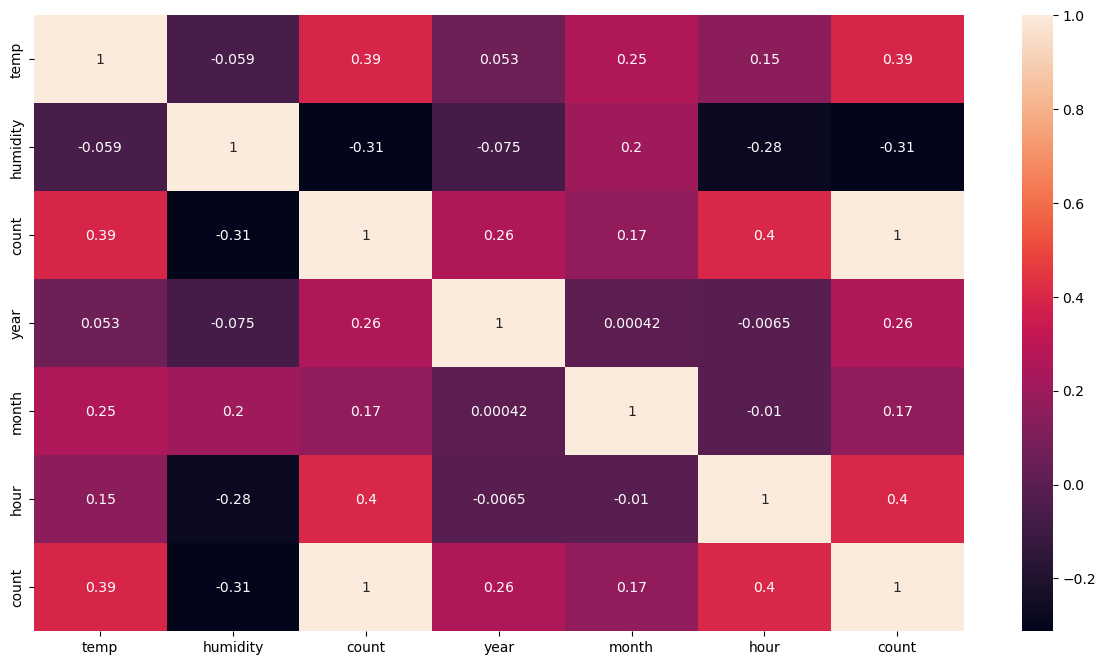

In [22]:
# Intermezzo heatmap
df_heatmap = pd.concat([X_train, y_train], axis=1)
plt.figure(figsize=(15,8))
sns.heatmap(df_heatmap.corr(), annot=True)

# Feature Engineering

In [23]:
cat_pipe = make_pipeline(OneHotEncoder(handle_unknown = "ignore", sparse = False))

pol_pipe = make_pipeline(PolynomialFeatures(degree = 4, interaction_only = False, include_bias = False))

bin_pipe2 = make_pipeline(KBinsDiscretizer(n_bins = 4, strategy = "kmeans"))

feature_transform = ColumnTransformer(transformers = [
    ("bin2", bin_pipe2, ["humidity", "temp"]),
    ("poly", pol_pipe, ["temp", "hour", "month", "humidity", "year"]),
    ("cat", cat_pipe, ["year", "month", "hour"])
])

X_train_transform = feature_transform.fit_transform(X_train)
X_test_transform = feature_transform.transform(X_test)
kaggle_transform = feature_transform.transform(kaggle_test)

/home/johanna/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Fit and Test

In [24]:
m = LinearRegression()
m = m.fit(X_train_transform, y_train)
ypred = m.predict(X_test_transform)

print(m.score(X_train_transform, y_train))
print(m.score(X_test_transform, y_test))

0.7560009095845783
0.770390024537133


In [25]:
# Cross-validation
cross_r2_lin = cross_val_score(m, X_train, y_train, cv = 5, scoring = "r2", verbose = 3)

sklearn.metrics.SCORERS.keys()
print(cross_r2_lin)
print(cross_r2_lin.mean())

[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[1. 1. 1. 1. 1.]
1.0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [26]:
# RMSLE
ypred[ypred < 0] = 0.0

np.sqrt(mean_squared_log_error(y_test, ypred))

0.8516764036117002

# Export for Upload

In [27]:
kaggle_lr = m.predict(kaggle_transform)
kaggle_lr[kaggle_lr < 0] = 0.0

kaggle_pred_lr = pd.DataFrame({"datetime": kaggle_test["datetime"], "count": kaggle_lr[0:]})

kaggle_pred_lr.to_csv("./output/kaggle_linear_regression.csv", index = False)